In [1]:
#We'll be using TF 2.1 and torchaudio

# try:
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
# !pip install soundfile                    #to save wav files
# !pip install --no-deps torchaudio==0.5.0

In [2]:
#Connecting Drive to save model checkpoints during training and to use custom data, uncomment if needed

# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Dataset download (Uncomment where needed)

#Arctic dataset for voice conversion

# !wget --header="Host: festvox.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: http://festvox.org/cmu_arctic/cmu_arctic/packed/" "http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_bdl_arctic-0.95-release.zip" -O "cmu_us_bdl_arctic-0.95-release.zip" -c
# !unzip -qq cmu_us_bdl_arctic-0.95-release.zip #MALE1
# !wget --header="Host: festvox.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: http://festvox.org/cmu_arctic/cmu_arctic/packed/" "http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_clb_arctic-0.95-release.zip" -O "cmu_us_clb_arctic-0.95-release.zip" -c
# !unzip -qq cmu_us_clb_arctic-0.95-release.zip #FEMALE1
# !wget --header="Host: festvox.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: http://festvox.org/cmu_arctic/cmu_arctic/packed/" "http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_rms_arctic-0.95-release.zip" -O "cmu_us_rms_arctic-0.95-release.zip" -c
# !unzip -qq cmu_us_rms_arctic-0.95-release.zip #MALE2
# !wget --header="Host: festvox.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: http://festvox.org/cmu_arctic/cmu_arctic/packed/" "http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_slt_arctic-0.95-release.zip" -O "cmu_us_slt_arctic-0.95-release.zip" -c
# !unzip -qq cmu_us_slt_arctic-0.95-release.zip #FEMALE2

# !wget http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_bdl_arctic-0.95-release.tar.bz2 #MALE1
# !tar -xf cmu_us_bdl_arctic-0.95-release.tar.bz2
# !wget http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_clb_arctic-0.95-release.tar.bz2 #FEMALE1
# !tar -xf cmu_us_clb_arctic-0.95-release.tar.bz2
# !wget http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_rms_arctic-0.95-release.tar.bz2 #MALE2
# !tar -xf cmu_us_rms_arctic-0.95-release.tar.bz2
# !wget http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_slt_arctic-0.95-release.tar.bz2 #FEMALE2
# !tar -xf cmu_us_slt_arctic-0.95-release.tar.bz2

#GTZAN dataset for music genre transfer
# !wget --header="Host: opihi.cs.uvic.ca" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: http://marsyas.info/downloads/datasets.html" "http://opihi.cs.uvic.ca/sound/genres.tar.gz" -O "genres.tar.gz" -c
# !tar -xzf genres.tar.gz

# !ls

# Preprocess

In [4]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [5]:
#Hyperparameters

hop=257               #hop size (window size = 6*hop)
sr=16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [6]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
from utils import *
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  S = wav2spectrum(np.array(waveform.detach().cpu()), N_FFT = 512)
  S = torch.tensor(S)
  return S
#   specgram = specfunc(waveform)
#   mel_specgram = melfunc(specgram)
#   return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def deprep(S):
  return spectrum2wav(S, N_FFT = 512)
  # S = denormalize(S)+ref_level_db
  # S = librosa.db_to_power(S)
  # wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
  # return np.array(np.squeeze(wv))

c:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (257) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [7]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object)
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*16000):
  x, sr = librosa.load(path,sr=16000)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    # x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x, sr = loadFile(ls[i], sampleRate=16000)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

In [8]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#MALE1
awv = audio_array('./input/bdl')                               #get waveform array from folder containing wav files
aspec = tospec(awv)                                                                 #get spectrogram array
adata = splitcut(aspec)                                                             #split spectrogams to fixed length
#FEMALE1
bwv = audio_array('./input/clb')
bspec = tospec(bwv)
bdata = splitcut(bspec)
# #MALE2
# awv = audio_array('../content/cmu_us_rms_arctic/wav')
# aspec = tospec(awv)
# adata = splitcut(aspec)
# #FEMALE2
# bwv = audio_array('../content/cmu_us_slt_arctic/wav')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

#JAZZ MUSIC
# awv = audio_array('../content/genres/jazz')
# aspec = tospec(awv)
# adata = splitcut(aspec)
#CLASSICAL MUSIC
# bwv = audio_array('../content/genres/classical')
# bspec = tospec(bwv)
# bdata = splitcut(bspec)

C:\Users\mmi36\AppData\Local\Temp/ipykernel_32516/368952498.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(adata)


(1132,)
(1132,)


# Dataset

In [9]:
#Creating Tensorflow Datasets

@tf.function
def proc(x):
  return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

# Model

In [10]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self.convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs


class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  
    
    
class DenseSN(Dense):
    
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [11]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [12]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  # print(gen.summary())
  # print(siam.summary())
  # print(critic.summary())
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  ab = gen(a, training=False)
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  # sf.write(path+'/new_file.wav', abwv, sr)
  writeFile(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='./saved_model'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [13]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [14]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

# Training

In [15]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  aa,aa2,aa3 = extract_image(a) 
  bb,bb2,bb3 = extract_image(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    #translating A to B
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
    fid = gen(bb, training=True) 
    fid2 = gen(bb2, training=True)
    fid3 = gen(bb3, training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)
    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  with tf.GradientTape() as tape_disc:

    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [16]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  c = 0
  g = 0
  
  for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
                      

In [17]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model = False, path='./saved_model')

Built networks


# Train

[Epoch 0/5000] [Batch 0] [D loss f: 1.0816278457641602 r: 0.941502034664154] [G loss: -0.08162788301706314] [ID loss: 0.3723837733268738] [LR: 0.0002]
[Epoch 0/5000] [Batch 600] [D loss f: 0.21213437616825104 r: 0.2788492441177368] [G loss: 1.5223535299301147] [ID loss: 0.2173887938261032] [LR: 0.0002]
[Epoch 0/5000] [Batch 1200] [D loss f: 0.4410543739795685 r: 0.532162606716156] [G loss: 1.0095142126083374] [ID loss: 0.1367287039756775] [LR: 0.0002]
[Epoch 0/5000] [Batch 1800] [D loss f: 0.5147014260292053 r: 0.5389601588249207] [G loss: 0.9955915212631226] [ID loss: 0.1046198159456253] [LR: 0.0002]
[Epoch 0/5000] [Batch 2400] [D loss f: 0.5306193232536316 r: 0.4754819869995117] [G loss: 0.9931125640869141] [ID loss: 0.08901152014732361] [LR: 0.0002]
[Epoch 0/5000] [Batch 3000] [D loss f: 0.5535397529602051 r: 0.4741145372390747] [G loss: 0.848166286945343] [ID loss: 0.08655333518981934] [LR: 0.0002]
[Epoch 0/5000] [Batch 3600] [D loss f: 0.5958581566810608 r: 0.42378443479537964] [G

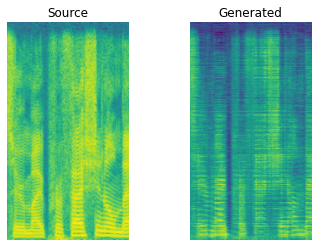

Mean D loss: 0.535638689994812 Mean G loss: 0.7637518048286438 Mean ID loss: 0.11872273683547974
[Epoch 1/5000] [Batch 0] [D loss f: 0.479925274848938 r: 0.32162901759147644] [G loss: 0.7102993726730347] [ID loss: 0.11441405862569809] [LR: 0.0002]
[Epoch 1/5000] [Batch 600] [D loss f: 0.46346232295036316 r: 0.3280152380466461] [G loss: 0.6653991341590881] [ID loss: 0.11130212247371674] [LR: 0.0002]
[Epoch 1/5000] [Batch 1200] [D loss f: 0.47503164410591125 r: 0.35484275221824646] [G loss: 0.663133978843689] [ID loss: 0.10550929605960846] [LR: 0.0002]
[Epoch 1/5000] [Batch 1800] [D loss f: 0.4677896201610565 r: 0.36734771728515625] [G loss: 0.6779453754425049] [ID loss: 0.10196671634912491] [LR: 0.0002]
[Epoch 1/5000] [Batch 2400] [D loss f: 0.4682314097881317 r: 0.3934957981109619] [G loss: 0.6887527704238892] [ID loss: 0.09243707358837128] [LR: 0.0002]
[Epoch 1/5000] [Batch 3000] [D loss f: 0.46309366822242737 r: 0.4120229184627533] [G loss: 0.6723858118057251] [ID loss: 0.08786980062

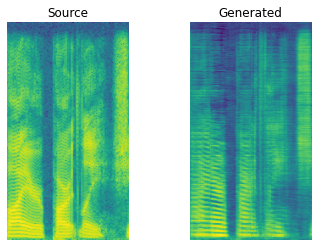

Mean D loss: 0.46980392932891846 Mean G loss: 0.6649007201194763 Mean ID loss: 0.08831387758255005
[Epoch 2/5000] [Batch 0] [D loss f: 0.485545814037323 r: 0.5940374732017517] [G loss: 0.6731542944908142] [ID loss: 0.0853012427687645] [LR: 0.0002]
[Epoch 2/5000] [Batch 600] [D loss f: 0.47991201281547546 r: 0.5908222198486328] [G loss: 0.6592172384262085] [ID loss: 0.08563384413719177] [LR: 0.0002]
[Epoch 2/5000] [Batch 1200] [D loss f: 0.46826252341270447 r: 0.6099655032157898] [G loss: 0.4643174111843109] [ID loss: 0.08779017627239227] [LR: 0.0002]
[Epoch 2/5000] [Batch 1800] [D loss f: 0.4749446511268616 r: 0.6034685969352722] [G loss: 0.6718198657035828] [ID loss: 0.08744878321886063] [LR: 0.0002]
[Epoch 2/5000] [Batch 2400] [D loss f: 0.47635605931282043 r: 0.5990811586380005] [G loss: 0.6349425315856934] [ID loss: 0.08609132468700409] [LR: 0.0002]
[Epoch 2/5000] [Batch 3000] [D loss f: 0.4877610206604004 r: 0.5881562232971191] [G loss: 0.6765198111534119] [ID loss: 0.083654791116

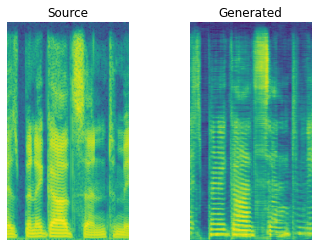

Mean D loss: 0.5055223107337952 Mean G loss: 0.6181830763816833 Mean ID loss: 0.08130456507205963
[Epoch 3/5000] [Batch 0] [D loss f: 0.5318905711174011 r: 0.5993362069129944] [G loss: 0.6352238059043884] [ID loss: 0.07911673933267593] [LR: 0.0002]
[Epoch 3/5000] [Batch 600] [D loss f: 0.5192937254905701 r: 0.6153750419616699] [G loss: 0.5748336911201477] [ID loss: 0.07961539179086685] [LR: 0.0002]
[Epoch 3/5000] [Batch 1200] [D loss f: 0.5368604063987732 r: 0.6128787994384766] [G loss: 0.6554126143455505] [ID loss: 0.07872331887483597] [LR: 0.0002]
[Epoch 3/5000] [Batch 1800] [D loss f: 0.5266163945198059 r: 0.6156189441680908] [G loss: 0.5556687712669373] [ID loss: 0.07880520075559616] [LR: 0.0002]
[Epoch 3/5000] [Batch 2400] [D loss f: 0.539334237575531 r: 0.6116105914115906] [G loss: 0.5603545308113098] [ID loss: 0.07901833951473236] [LR: 0.0002]
[Epoch 3/5000] [Batch 3000] [D loss f: 0.5499626398086548 r: 0.6084523797035217] [G loss: 0.6066870093345642] [ID loss: 0.078750461339950

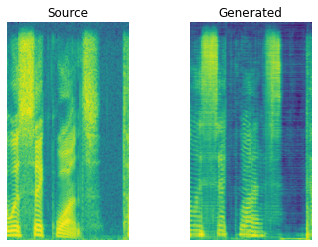

Mean D loss: 0.5505539774894714 Mean G loss: 0.588573157787323 Mean ID loss: 0.07846411317586899
[Epoch 4/5000] [Batch 0] [D loss f: 0.5692901611328125 r: 0.6216222643852234] [G loss: 0.5395259261131287] [ID loss: 0.07829530537128448] [LR: 0.0002]
[Epoch 4/5000] [Batch 600] [D loss f: 0.5641920566558838 r: 0.6413648128509521] [G loss: 0.5327057838439941] [ID loss: 0.07776634395122528] [LR: 0.0002]
[Epoch 4/5000] [Batch 1200] [D loss f: 0.5636350512504578 r: 0.6465473175048828] [G loss: 0.5842092633247375] [ID loss: 0.07845322042703629] [LR: 0.0002]
[Epoch 4/5000] [Batch 1800] [D loss f: 0.5652883052825928 r: 0.6359336376190186] [G loss: 0.6222223043441772] [ID loss: 0.0780545175075531] [LR: 0.0002]
[Epoch 4/5000] [Batch 2400] [D loss f: 0.5630390644073486 r: 0.6479167342185974] [G loss: 0.5763366222381592] [ID loss: 0.07766973972320557] [LR: 0.0002]
[Epoch 4/5000] [Batch 3000] [D loss f: 0.5699597001075745 r: 0.6443023681640625] [G loss: 0.5539975762367249] [ID loss: 0.0775974988937377

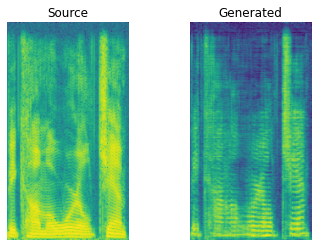

Mean D loss: 0.5673410892486572 Mean G loss: 0.5529979467391968 Mean ID loss: 0.07802490144968033
[Epoch 5/5000] [Batch 0] [D loss f: 0.5816181302070618 r: 0.6733692288398743] [G loss: 0.4993564486503601] [ID loss: 0.07701084017753601] [LR: 0.0002]
[Epoch 5/5000] [Batch 600] [D loss f: 0.5940943360328674 r: 0.6627335548400879] [G loss: 0.6043489575386047] [ID loss: 0.07714521139860153] [LR: 0.0002]
[Epoch 5/5000] [Batch 1200] [D loss f: 0.573201596736908 r: 0.6654391288757324] [G loss: 0.5521623492240906] [ID loss: 0.0772809237241745] [LR: 0.0002]
[Epoch 5/5000] [Batch 1800] [D loss f: 0.5805095434188843 r: 0.6726897358894348] [G loss: 0.5078792572021484] [ID loss: 0.07718121260404587] [LR: 0.0002]
[Epoch 5/5000] [Batch 2400] [D loss f: 0.5727130174636841 r: 0.6822543740272522] [G loss: 0.5153475999832153] [ID loss: 0.07770700752735138] [LR: 0.0002]
[Epoch 5/5000] [Batch 3000] [D loss f: 0.5698122978210449 r: 0.6698500514030457] [G loss: 0.5188617706298828] [ID loss: 0.0778454393148422

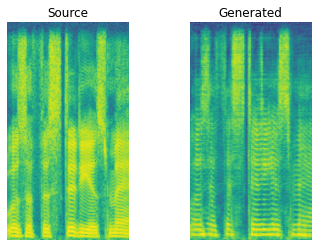

Mean D loss: 0.5859071016311646 Mean G loss: 0.5219842791557312 Mean ID loss: 0.07744437456130981
[Epoch 6/5000] [Batch 0] [D loss f: 0.5821125507354736 r: 0.7050767540931702] [G loss: 0.5128346681594849] [ID loss: 0.07743605226278305] [LR: 0.0002]
[Epoch 6/5000] [Batch 600] [D loss f: 0.5932952761650085 r: 0.6975328922271729] [G loss: 0.4787202477455139] [ID loss: 0.07785734534263611] [LR: 0.0002]
[Epoch 6/5000] [Batch 1200] [D loss f: 0.5946351885795593 r: 0.6976006627082825] [G loss: 0.5616646409034729] [ID loss: 0.0774821937084198] [LR: 0.0002]
[Epoch 6/5000] [Batch 1800] [D loss f: 0.5916117429733276 r: 0.6920664310455322] [G loss: 0.5264478325843811] [ID loss: 0.07720490545034409] [LR: 0.0002]
[Epoch 6/5000] [Batch 2400] [D loss f: 0.6018477082252502 r: 0.6980207562446594] [G loss: 0.4813387095928192] [ID loss: 0.07706848531961441] [LR: 0.0002]
[Epoch 6/5000] [Batch 3000] [D loss f: 0.5986703634262085 r: 0.6955229640007019] [G loss: 0.5387964844703674] [ID loss: 0.077274508774280

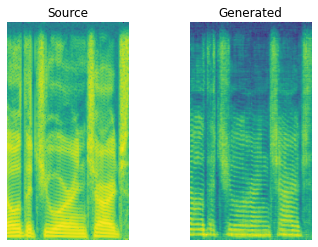

Mean D loss: 0.6016537547111511 Mean G loss: 0.5047982335090637 Mean ID loss: 0.07721224427223206
[Epoch 7/5000] [Batch 0] [D loss f: 0.5954089164733887 r: 0.7119396328926086] [G loss: 0.5074828863143921] [ID loss: 0.0771867036819458] [LR: 0.0002]
[Epoch 7/5000] [Batch 600] [D loss f: 0.6108683347702026 r: 0.7158418893814087] [G loss: 0.5197159051895142] [ID loss: 0.0770704373717308] [LR: 0.0002]
[Epoch 7/5000] [Batch 1200] [D loss f: 0.6126846075057983 r: 0.712957501411438] [G loss: 0.5469532012939453] [ID loss: 0.0771215409040451] [LR: 0.0002]
[Epoch 7/5000] [Batch 1800] [D loss f: 0.623860776424408 r: 0.7028297185897827] [G loss: 0.44175297021865845] [ID loss: 0.07697214931249619] [LR: 0.0002]
[Epoch 7/5000] [Batch 2400] [D loss f: 0.6020843386650085 r: 0.733856201171875] [G loss: 0.43021297454833984] [ID loss: 0.07692959904670715] [LR: 0.0002]
[Epoch 7/5000] [Batch 3000] [D loss f: 0.6019400954246521 r: 0.723586916923523] [G loss: 0.5142762064933777] [ID loss: 0.07722204923629761] 

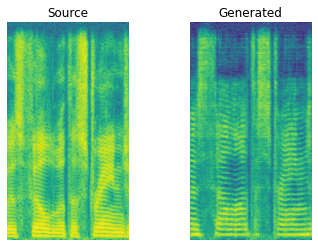

Mean D loss: 0.6136602163314819 Mean G loss: 0.49268659949302673 Mean ID loss: 0.07691311091184616
[Epoch 8/5000] [Batch 0] [D loss f: 0.6337002515792847 r: 0.7197809219360352] [G loss: 0.4671761393547058] [ID loss: 0.07585492730140686] [LR: 0.0002]
[Epoch 8/5000] [Batch 600] [D loss f: 0.6209958791732788 r: 0.7464309930801392] [G loss: 0.4189310669898987] [ID loss: 0.07641390711069107] [LR: 0.0002]
[Epoch 8/5000] [Batch 1200] [D loss f: 0.6081774234771729 r: 0.7494412064552307] [G loss: 0.4431767761707306] [ID loss: 0.07661598920822144] [LR: 0.0002]
[Epoch 8/5000] [Batch 1800] [D loss f: 0.6238172650337219 r: 0.7283035516738892] [G loss: 0.4912418723106384] [ID loss: 0.0762178897857666] [LR: 0.0002]
[Epoch 8/5000] [Batch 2400] [D loss f: 0.6201969385147095 r: 0.7378250360488892] [G loss: 0.4709712266921997] [ID loss: 0.07622665911912918] [LR: 0.0002]
[Epoch 8/5000] [Batch 3000] [D loss f: 0.6105973124504089 r: 0.7454699873924255] [G loss: 0.45105814933776855] [ID loss: 0.0767144039273

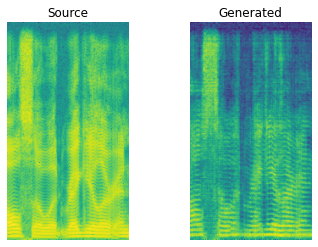

Mean D loss: 0.6207277774810791 Mean G loss: 0.4785151779651642 Mean ID loss: 0.07634387165307999
[Epoch 9/5000] [Batch 0] [D loss f: 0.6342588663101196 r: 0.7433949708938599] [G loss: 0.3707677125930786] [ID loss: 0.07624999433755875] [LR: 0.0002]
[Epoch 9/5000] [Batch 600] [D loss f: 0.6303954124450684 r: 0.7480942606925964] [G loss: 0.48708322644233704] [ID loss: 0.0761968195438385] [LR: 0.0002]
[Epoch 9/5000] [Batch 1200] [D loss f: 0.6234681010246277 r: 0.745833158493042] [G loss: 0.45995253324508667] [ID loss: 0.07593701034784317] [LR: 0.0002]
[Epoch 9/5000] [Batch 1800] [D loss f: 0.6231756806373596 r: 0.7442628145217896] [G loss: 0.45691534876823425] [ID loss: 0.0761805921792984] [LR: 0.0002]
[Epoch 9/5000] [Batch 2400] [D loss f: 0.6210547089576721 r: 0.7583838105201721] [G loss: 0.45981070399284363] [ID loss: 0.07603343576192856] [LR: 0.0002]
[Epoch 9/5000] [Batch 3000] [D loss f: 0.6221346855163574 r: 0.7648955583572388] [G loss: 0.3498910367488861] [ID loss: 0.0764994546771

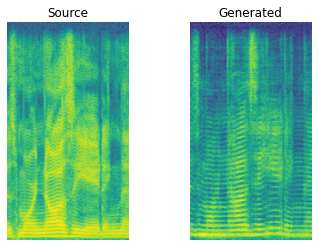

Mean D loss: 0.6244779825210571 Mean G loss: 0.4629004895687103 Mean ID loss: 0.07598406821489334
[Epoch 10/5000] [Batch 0] [D loss f: 0.610472559928894 r: 0.756293773651123] [G loss: 0.5522295832633972] [ID loss: 0.07487740367650986] [LR: 0.0002]
[Epoch 10/5000] [Batch 600] [D loss f: 0.6396183371543884 r: 0.7285085916519165] [G loss: 0.5006647706031799] [ID loss: 0.07515422999858856] [LR: 0.0002]
[Epoch 10/5000] [Batch 1200] [D loss f: 0.6485278606414795 r: 0.7325007319450378] [G loss: 0.4534904956817627] [ID loss: 0.07513434439897537] [LR: 0.0002]
[Epoch 10/5000] [Batch 1800] [D loss f: 0.636433482170105 r: 0.7384476661682129] [G loss: 0.4299752712249756] [ID loss: 0.07568678259849548] [LR: 0.0002]
[Epoch 10/5000] [Batch 2400] [D loss f: 0.651528537273407 r: 0.7235908508300781] [G loss: 0.5354808568954468] [ID loss: 0.07531467080116272] [LR: 0.0002]
[Epoch 10/5000] [Batch 3000] [D loss f: 0.6381067633628845 r: 0.7461559772491455] [G loss: 0.46964672207832336] [ID loss: 0.07524987310

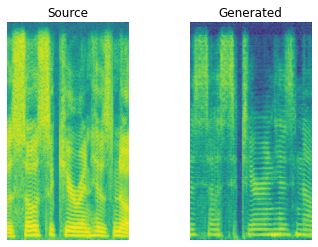

Mean D loss: 0.6329312920570374 Mean G loss: 0.468126118183136 Mean ID loss: 0.07549944519996643
[Epoch 11/5000] [Batch 0] [D loss f: 0.6235603094100952 r: 0.7706887125968933] [G loss: 0.46451321244239807] [ID loss: 0.07620561867952347] [LR: 0.0002]
[Epoch 11/5000] [Batch 600] [D loss f: 0.6247260570526123 r: 0.7817946076393127] [G loss: 0.4071281850337982] [ID loss: 0.07565217465162277] [LR: 0.0002]
[Epoch 11/5000] [Batch 1200] [D loss f: 0.6328651309013367 r: 0.7711697220802307] [G loss: 0.4997556507587433] [ID loss: 0.07558616995811462] [LR: 0.0002]
[Epoch 11/5000] [Batch 1800] [D loss f: 0.6170632839202881 r: 0.7801044583320618] [G loss: 0.41544386744499207] [ID loss: 0.07551992684602737] [LR: 0.0002]
[Epoch 11/5000] [Batch 2400] [D loss f: 0.621289074420929 r: 0.7742098569869995] [G loss: 0.4525734484195709] [ID loss: 0.07532718777656555] [LR: 0.0002]
[Epoch 11/5000] [Batch 3000] [D loss f: 0.6145267486572266 r: 0.776793897151947] [G loss: 0.4743504822254181] [ID loss: 0.075474865

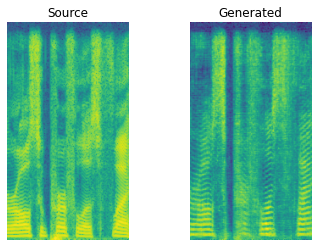

Mean D loss: 0.6307308673858643 Mean G loss: 0.45224815607070923 Mean ID loss: 0.07515127956867218
[Epoch 12/5000] [Batch 0] [D loss f: 0.6106329560279846 r: 0.7817737460136414] [G loss: 0.4378117620944977] [ID loss: 0.07499141246080399] [LR: 0.0002]
[Epoch 12/5000] [Batch 600] [D loss f: 0.6301056146621704 r: 0.771375298500061] [G loss: 0.4572783410549164] [ID loss: 0.07499057054519653] [LR: 0.0002]
[Epoch 12/5000] [Batch 1200] [D loss f: 0.6346516013145447 r: 0.771489679813385] [G loss: 0.48355838656425476] [ID loss: 0.0749049186706543] [LR: 0.0002]
[Epoch 12/5000] [Batch 1800] [D loss f: 0.6303590536117554 r: 0.7761925458908081] [G loss: 0.4512743651866913] [ID loss: 0.07504994422197342] [LR: 0.0002]
[Epoch 12/5000] [Batch 2400] [D loss f: 0.6503746509552002 r: 0.7567986845970154] [G loss: 0.4155195951461792] [ID loss: 0.07468660920858383] [LR: 0.0002]
[Epoch 12/5000] [Batch 3000] [D loss f: 0.6408803462982178 r: 0.7662540674209595] [G loss: 0.43465641140937805] [ID loss: 0.07523912

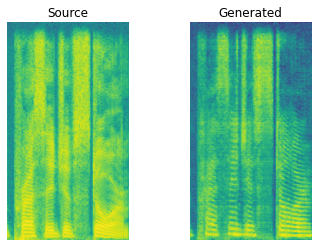

Mean D loss: 0.6419057846069336 Mean G loss: 0.45022666454315186 Mean ID loss: 0.07474329322576523
[Epoch 13/5000] [Batch 0] [D loss f: 0.6430496573448181 r: 0.7679641246795654] [G loss: 0.4174065887928009] [ID loss: 0.0743684470653534] [LR: 0.0002]
[Epoch 13/5000] [Batch 600] [D loss f: 0.6339936256408691 r: 0.7704757452011108] [G loss: 0.45099112391471863] [ID loss: 0.07473289221525192] [LR: 0.0002]
[Epoch 13/5000] [Batch 1200] [D loss f: 0.6434074640274048 r: 0.7695081233978271] [G loss: 0.3996151387691498] [ID loss: 0.07493199408054352] [LR: 0.0002]
[Epoch 13/5000] [Batch 1800] [D loss f: 0.6311585903167725 r: 0.7700294852256775] [G loss: 0.4484533667564392] [ID loss: 0.07504841685295105] [LR: 0.0002]
[Epoch 13/5000] [Batch 2400] [D loss f: 0.6335430145263672 r: 0.7701905369758606] [G loss: 0.45708566904067993] [ID loss: 0.0746295228600502] [LR: 0.0002]
[Epoch 13/5000] [Batch 3000] [D loss f: 0.6387271881103516 r: 0.7618461847305298] [G loss: 0.5168891549110413] [ID loss: 0.0743898

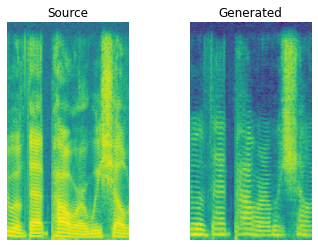

Mean D loss: 0.6393483877182007 Mean G loss: 0.45160406827926636 Mean ID loss: 0.07441633939743042
[Epoch 14/5000] [Batch 0] [D loss f: 0.6406503319740295 r: 0.7582229971885681] [G loss: 0.4296388328075409] [ID loss: 0.07472454011440277] [LR: 0.0002]
[Epoch 14/5000] [Batch 600] [D loss f: 0.6291326880455017 r: 0.7816663384437561] [G loss: 0.4415219724178314] [ID loss: 0.07422774285078049] [LR: 0.0002]
[Epoch 14/5000] [Batch 1200] [D loss f: 0.6357700824737549 r: 0.7704720497131348] [G loss: 0.42937687039375305] [ID loss: 0.07438631355762482] [LR: 0.0002]
[Epoch 14/5000] [Batch 1800] [D loss f: 0.6312136054039001 r: 0.7797427177429199] [G loss: 0.4271412193775177] [ID loss: 0.07481445372104645] [LR: 0.0002]
[Epoch 14/5000] [Batch 2400] [D loss f: 0.6448968052864075 r: 0.772537350654602] [G loss: 0.44090574979782104] [ID loss: 0.07426616549491882] [LR: 0.0002]
[Epoch 14/5000] [Batch 3000] [D loss f: 0.6324674487113953 r: 0.7887270450592041] [G loss: 0.49272286891937256] [ID loss: 0.07433

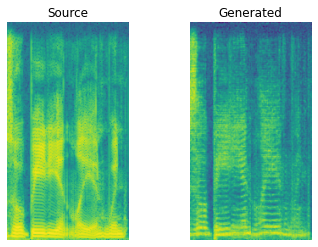

Mean D loss: 0.6413674354553223 Mean G loss: 0.4371767044067383 Mean ID loss: 0.07428035885095596
[Epoch 15/5000] [Batch 0] [D loss f: 0.6511625647544861 r: 0.76045823097229] [G loss: 0.4024728834629059] [ID loss: 0.07415187358856201] [LR: 0.0002]
[Epoch 15/5000] [Batch 600] [D loss f: 0.6543476581573486 r: 0.7652042508125305] [G loss: 0.4509962499141693] [ID loss: 0.07422104477882385] [LR: 0.0002]
[Epoch 15/5000] [Batch 1200] [D loss f: 0.6483638286590576 r: 0.760940432548523] [G loss: 0.4184844195842743] [ID loss: 0.07441429048776627] [LR: 0.0002]
[Epoch 15/5000] [Batch 1800] [D loss f: 0.6603700518608093 r: 0.7568645477294922] [G loss: 0.4508735239505768] [ID loss: 0.07426425814628601] [LR: 0.0002]
[Epoch 15/5000] [Batch 2400] [D loss f: 0.6425390839576721 r: 0.7629813551902771] [G loss: 0.4407517910003662] [ID loss: 0.07417858392000198] [LR: 0.0002]
[Epoch 15/5000] [Batch 3000] [D loss f: 0.6527275443077087 r: 0.7676376104354858] [G loss: 0.45418664813041687] [ID loss: 0.0739272460

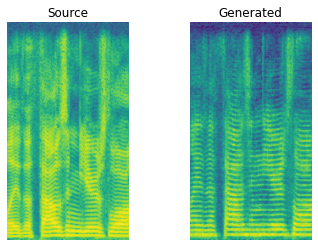

Mean D loss: 0.6466146111488342 Mean G loss: 0.42985114455223083 Mean ID loss: 0.07410523295402527
[Epoch 16/5000] [Batch 0] [D loss f: 0.6268166303634644 r: 0.7957091927528381] [G loss: 0.44560861587524414] [ID loss: 0.07439526170492172] [LR: 0.0002]
[Epoch 16/5000] [Batch 600] [D loss f: 0.6474007964134216 r: 0.7782607078552246] [G loss: 0.3879570960998535] [ID loss: 0.07419872283935547] [LR: 0.0002]
[Epoch 16/5000] [Batch 1200] [D loss f: 0.646159827709198 r: 0.7785704731941223] [G loss: 0.4495026767253876] [ID loss: 0.07421308755874634] [LR: 0.0002]
[Epoch 16/5000] [Batch 1800] [D loss f: 0.6621593236923218 r: 0.7739146947860718] [G loss: 0.3956555724143982] [ID loss: 0.07388270646333694] [LR: 0.0002]
[Epoch 16/5000] [Batch 2400] [D loss f: 0.6317775249481201 r: 0.7972051501274109] [G loss: 0.43913349509239197] [ID loss: 0.07376410812139511] [LR: 0.0002]
[Epoch 16/5000] [Batch 3000] [D loss f: 0.6346985697746277 r: 0.7894052267074585] [G loss: 0.43487468361854553] [ID loss: 0.07379

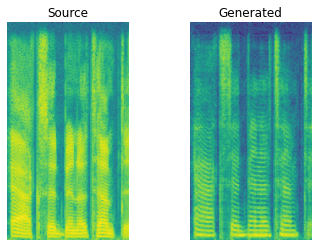

Mean D loss: 0.6501044631004333 Mean G loss: 0.4279693067073822 Mean ID loss: 0.07372613996267319
[Epoch 17/5000] [Batch 0] [D loss f: 0.6419543027877808 r: 0.7778377532958984] [G loss: 0.4179590046405792] [ID loss: 0.07298675179481506] [LR: 0.0002]
[Epoch 17/5000] [Batch 600] [D loss f: 0.6469838619232178 r: 0.7843378782272339] [G loss: 0.4090525507926941] [ID loss: 0.07337769865989685] [LR: 0.0002]
[Epoch 17/5000] [Batch 1200] [D loss f: 0.6518425345420837 r: 0.7797583341598511] [G loss: 0.42129361629486084] [ID loss: 0.07324029505252838] [LR: 0.0002]
[Epoch 17/5000] [Batch 1800] [D loss f: 0.6366553902626038 r: 0.7872450947761536] [G loss: 0.4411852955818176] [ID loss: 0.07321747392416] [LR: 0.0002]
[Epoch 17/5000] [Batch 2400] [D loss f: 0.6473684310913086 r: 0.7797895073890686] [G loss: 0.39586901664733887] [ID loss: 0.07384438812732697] [LR: 0.0002]
[Epoch 17/5000] [Batch 3000] [D loss f: 0.6482317447662354 r: 0.7917740941047668] [G loss: 0.3974841833114624] [ID loss: 0.073426865

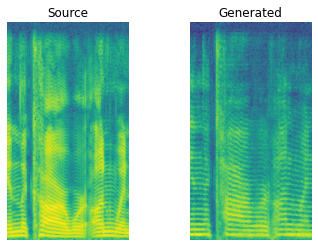

Mean D loss: 0.6498403549194336 Mean G loss: 0.4239392578601837 Mean ID loss: 0.0733998566865921
[Epoch 18/5000] [Batch 0] [D loss f: 0.6507160663604736 r: 0.7646548748016357] [G loss: 0.46656399965286255] [ID loss: 0.07356277853250504] [LR: 0.0002]
[Epoch 18/5000] [Batch 600] [D loss f: 0.6543726921081543 r: 0.776606023311615] [G loss: 0.38815176486968994] [ID loss: 0.07327017188072205] [LR: 0.0002]
[Epoch 18/5000] [Batch 1200] [D loss f: 0.6546685695648193 r: 0.7878502607345581] [G loss: 0.45487529039382935] [ID loss: 0.07315880805253983] [LR: 0.0002]
[Epoch 18/5000] [Batch 1800] [D loss f: 0.6560810208320618 r: 0.7841547727584839] [G loss: 0.38046935200691223] [ID loss: 0.07315754890441895] [LR: 0.0002]
[Epoch 18/5000] [Batch 2400] [D loss f: 0.6510453224182129 r: 0.7950528860092163] [G loss: 0.3900813162326813] [ID loss: 0.07304340600967407] [LR: 0.0002]
[Epoch 18/5000] [Batch 3000] [D loss f: 0.6527354717254639 r: 0.7832494378089905] [G loss: 0.40986087918281555] [ID loss: 0.07312

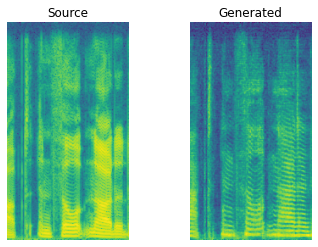

Mean D loss: 0.6523253321647644 Mean G loss: 0.41778796911239624 Mean ID loss: 0.07318399101495743
[Epoch 19/5000] [Batch 0] [D loss f: 0.6318860054016113 r: 0.8013423681259155] [G loss: 0.46730631589889526] [ID loss: 0.0731799378991127] [LR: 0.0002]
[Epoch 19/5000] [Batch 600] [D loss f: 0.6339365839958191 r: 0.8078781366348267] [G loss: 0.421112984418869] [ID loss: 0.07294637709856033] [LR: 0.0002]
[Epoch 19/5000] [Batch 1200] [D loss f: 0.6568449139595032 r: 0.7828202247619629] [G loss: 0.38792678713798523] [ID loss: 0.07314476370811462] [LR: 0.0002]
[Epoch 19/5000] [Batch 1800] [D loss f: 0.6432639360427856 r: 0.7888063788414001] [G loss: 0.4425390660762787] [ID loss: 0.07312382012605667] [LR: 0.0002]
[Epoch 19/5000] [Batch 2400] [D loss f: 0.6272518634796143 r: 0.8003828525543213] [G loss: 0.4047625660896301] [ID loss: 0.07313498854637146] [LR: 0.0002]
[Epoch 19/5000] [Batch 3000] [D loss f: 0.6422415375709534 r: 0.7970804572105408] [G loss: 0.4315473437309265] [ID loss: 0.0729119

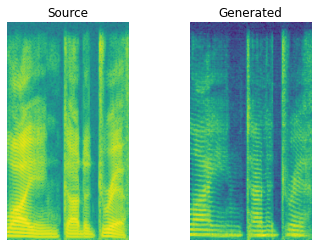

Mean D loss: 0.6505468487739563 Mean G loss: 0.41543927788734436 Mean ID loss: 0.07302237302064896
[Epoch 20/5000] [Batch 0] [D loss f: 0.6405093669891357 r: 0.808979332447052] [G loss: 0.36865919828414917] [ID loss: 0.07275060564279556] [LR: 0.0002]
[Epoch 20/5000] [Batch 600] [D loss f: 0.655419111251831 r: 0.7842578291893005] [G loss: 0.44505712389945984] [ID loss: 0.07287424802780151] [LR: 0.0002]
[Epoch 20/5000] [Batch 1200] [D loss f: 0.654057502746582 r: 0.79466712474823] [G loss: 0.3864564299583435] [ID loss: 0.07295671850442886] [LR: 0.0002]
[Epoch 20/5000] [Batch 1800] [D loss f: 0.6585618853569031 r: 0.7851426005363464] [G loss: 0.39935439825057983] [ID loss: 0.07278676331043243] [LR: 0.0002]
[Epoch 20/5000] [Batch 2400] [D loss f: 0.6398101449012756 r: 0.8059232831001282] [G loss: 0.3863394260406494] [ID loss: 0.07277285307645798] [LR: 0.0002]
[Epoch 20/5000] [Batch 3000] [D loss f: 0.664779543876648 r: 0.7737563252449036] [G loss: 0.4486575424671173] [ID loss: 0.0729357749

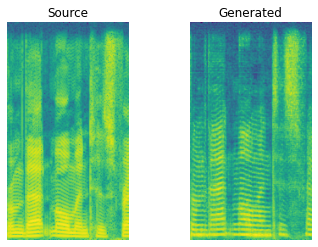

Mean D loss: 0.6618146300315857 Mean G loss: 0.4221440553665161 Mean ID loss: 0.07269872725009918
[Epoch 21/5000] [Batch 0] [D loss f: 0.6716471910476685 r: 0.773809552192688] [G loss: 0.48962634801864624] [ID loss: 0.07259537279605865] [LR: 0.0002]
[Epoch 21/5000] [Batch 600] [D loss f: 0.672185480594635 r: 0.7809374928474426] [G loss: 0.4352445602416992] [ID loss: 0.072456955909729] [LR: 0.0002]
[Epoch 21/5000] [Batch 1200] [D loss f: 0.6509889960289001 r: 0.789998471736908] [G loss: 0.4289359152317047] [ID loss: 0.07258803397417068] [LR: 0.0002]
[Epoch 21/5000] [Batch 1800] [D loss f: 0.6673403978347778 r: 0.7733020186424255] [G loss: 0.4154336452484131] [ID loss: 0.07255793362855911] [LR: 0.0002]
[Epoch 21/5000] [Batch 2400] [D loss f: 0.6726915240287781 r: 0.7818026542663574] [G loss: 0.42119741439819336] [ID loss: 0.0725446566939354] [LR: 0.0002]
[Epoch 21/5000] [Batch 3000] [D loss f: 0.6625669002532959 r: 0.7769911885261536] [G loss: 0.4100746810436249] [ID loss: 0.072828218340

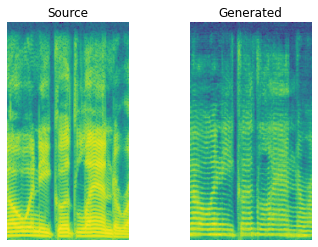

Mean D loss: 0.6575958728790283 Mean G loss: 0.4202924370765686 Mean ID loss: 0.072507843375206
[Epoch 22/5000] [Batch 0] [D loss f: 0.6704486608505249 r: 0.778597354888916] [G loss: 0.4619356393814087] [ID loss: 0.07223956286907196] [LR: 0.0002]
[Epoch 22/5000] [Batch 600] [D loss f: 0.6744707226753235 r: 0.777029275894165] [G loss: 0.44108423590660095] [ID loss: 0.07223048061132431] [LR: 0.0002]
[Epoch 22/5000] [Batch 1200] [D loss f: 0.6625480651855469 r: 0.7826189398765564] [G loss: 0.3871614634990692] [ID loss: 0.07212937623262405] [LR: 0.0002]
[Epoch 22/5000] [Batch 1800] [D loss f: 0.6681249141693115 r: 0.7771559357643127] [G loss: 0.42234861850738525] [ID loss: 0.07242194563150406] [LR: 0.0002]
[Epoch 22/5000] [Batch 2400] [D loss f: 0.6507467031478882 r: 0.8003972172737122] [G loss: 0.4346412122249603] [ID loss: 0.07236699759960175] [LR: 0.0002]
[Epoch 22/5000] [Batch 3000] [D loss f: 0.662912130355835 r: 0.7876366972923279] [G loss: 0.4081529378890991] [ID loss: 0.07240834832

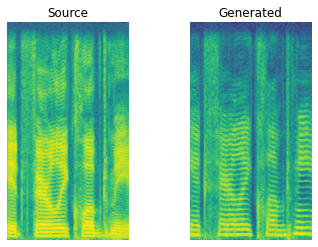

Mean D loss: 0.662553071975708 Mean G loss: 0.41844210028648376 Mean ID loss: 0.07226052135229111
[Epoch 23/5000] [Batch 0] [D loss f: 0.6482828259468079 r: 0.7996479868888855] [G loss: 0.37225720286369324] [ID loss: 0.07227378338575363] [LR: 0.0002]
[Epoch 23/5000] [Batch 600] [D loss f: 0.632824182510376 r: 0.8167497515678406] [G loss: 0.40511855483055115] [ID loss: 0.07229561358690262] [LR: 0.0002]
[Epoch 23/5000] [Batch 1200] [D loss f: 0.6745696663856506 r: 0.7845207452774048] [G loss: 0.3934575021266937] [ID loss: 0.07238934189081192] [LR: 0.0002]
[Epoch 23/5000] [Batch 1800] [D loss f: 0.6565248370170593 r: 0.8020599484443665] [G loss: 0.3826415538787842] [ID loss: 0.0723404809832573] [LR: 0.0002]
[Epoch 23/5000] [Batch 2400] [D loss f: 0.6614454388618469 r: 0.7972357869148254] [G loss: 0.4282603859901428] [ID loss: 0.07228973507881165] [LR: 0.0002]
[Epoch 23/5000] [Batch 3000] [D loss f: 0.6599287986755371 r: 0.7821729183197021] [G loss: 0.3905022144317627] [ID loss: 0.07247775

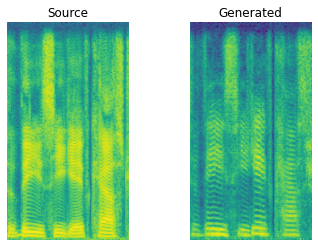

Mean D loss: 0.6577492356300354 Mean G loss: 0.40404027700424194 Mean ID loss: 0.07223153114318848
[Epoch 24/5000] [Batch 0] [D loss f: 0.6574562191963196 r: 0.81111741065979] [G loss: 0.43844839930534363] [ID loss: 0.07182053476572037] [LR: 0.0002]
[Epoch 24/5000] [Batch 600] [D loss f: 0.6549866199493408 r: 0.8067582845687866] [G loss: 0.3727457821369171] [ID loss: 0.0720544084906578] [LR: 0.0002]
[Epoch 24/5000] [Batch 1200] [D loss f: 0.6591760516166687 r: 0.8000840544700623] [G loss: 0.4160389304161072] [ID loss: 0.07179325073957443] [LR: 0.0002]
[Epoch 24/5000] [Batch 1800] [D loss f: 0.6694239377975464 r: 0.7905995845794678] [G loss: 0.382769376039505] [ID loss: 0.07192414999008179] [LR: 0.0002]
[Epoch 24/5000] [Batch 2400] [D loss f: 0.6615853309631348 r: 0.7894462943077087] [G loss: 0.3955315947532654] [ID loss: 0.07217987626791] [LR: 0.0002]
[Epoch 24/5000] [Batch 3000] [D loss f: 0.6588839888572693 r: 0.8031583428382874] [G loss: 0.3565662205219269] [ID loss: 0.0718883126974

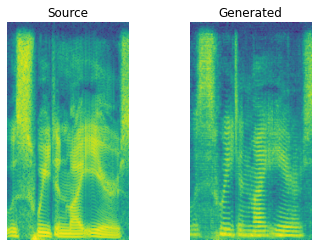

Mean D loss: 0.6626559495925903 Mean G loss: 0.3959009051322937 Mean ID loss: 0.07188344746828079
[Epoch 25/5000] [Batch 0] [D loss f: 0.6588408350944519 r: 0.7898131012916565] [G loss: 0.4481031894683838] [ID loss: 0.07174171507358551] [LR: 0.0002]
[Epoch 25/5000] [Batch 600] [D loss f: 0.6553015112876892 r: 0.8100837469100952] [G loss: 0.4009789228439331] [ID loss: 0.07162747532129288] [LR: 0.0002]
[Epoch 25/5000] [Batch 1200] [D loss f: 0.6653763055801392 r: 0.786405622959137] [G loss: 0.4219546616077423] [ID loss: 0.07174203544855118] [LR: 0.0002]


KeyboardInterrupt: 

In [18]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(5000, batch_size=bs, lr=0.0002, n_save=1, gupt=3)

# Test

In [ ]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

In [ ]:
#Wav to wav conversion

wv, sr = librosa.load(librosa.util.example_audio_file(), sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME1', path='../content/')           #Convert and save wav